# Compute a Julia set with CUDA
**Author**: Stephan Hageboeck, CERN

In this notebook, we will write a simple GPU kernel to approximate a Julia (and a Fatou) set. For a complex number $z$ and a function $f(z)$,
- the Julia set is the set of numbers that is completely invariant under repeated application of $f(z)$,
- and the Fatou set is the complement of the Julia set.

See e.g. the [Wikipedia](https://en.wikipedia.org/wiki/Julia_set) for more details on Julia/Fatou sets.

For $f(z)$, we will use the following polynomial:
\[
 f(z) = z^2 + c,
\]

where $c$ is a complex number that we can choose. If we apply this function repeatedly to $z$, and $z$ blows up quickly, it is part of the Fatou set. We will explore the behaviour of $f(z)$ on a complex plane of 1024x1024 pixels, so we will have to apply our function a few hundred times to more than one million numbers, which is an excellent task for a GPU. For each point on the complex plane, we will keep applying the function until either the number blows up, or the maximum number of iterations is reached. Depending on how fast the number blows up, we will colour the pixel in the complex plane.

This can look as follows for $f(z) = z^2 - 0.4 + 0.6i$:
<img src="../julia_detail/julia2.png" width="400">

## CUDA progamming in a notebook?
It is indeed a bit ununsual to program CUDA in a Python notebook. We will use a few tricks to make it work. The notebook provides a uniform environment to all participants, such that we can access the SWAN GPUs without having to worry about the operating systems and installed software every participant brings. In order to compile the cuda programs, we will
- write a notebook cell into a `.cu` file
- compile it using the nvcc compiler
- invoke the application from the notebook
- and convert the image such that the notebook can display it.


## The Julia kernel
Below we have a draft cuda program to approximate the Julia/Fatou sets. We want to create a kernel that applies $f(z)$ to each point in the complex plane for `maxIter` times or until $z$ starts to diverge. The floating-point coordinates for a pixel at index `(i, j)` have already been computed, but you have to figure out the correct pixel indices and write the loop to repeatedly apply the function $f(z)$.

### Tasks
1. In the `main()` function, allocate memory for all pixels. The writePPM function expects an array of pixels in the form `{y0={x0 x1 x2 x3 ...}, y1={x0 x1 x2 x3 ...}, ... y_n }`, so allocate a one-dimensional array with enough memory for x*y pixels. There's already a section that checks for possible cuda errors, so allocate the memory just before. Don't forget to free the memory when you're done.
1. Launch the draft kernel from the main function. Check for possible errors.
1. Figure out a way to compute the pixel indices `i` and `j` from `threadIdx.x` and `blockIdx.x`. Find a kernel launch configuration that covers the entire image.
1. Implement the computation `z = z^2 + c`.
  - We will not use any external complex number classes for this, so square the complex number by hand.
  - Plug the computation in the loop. Check that it runs
    - for a maximum of `maxIter` times
    - or until z starts to diverge (`|z| >= maxMagnitude`).
  - Check that the iteration at which z diverged is recorded in the pixel array. If it didn't diverge (e.g. because the point is part of the Julia set), set the pixel to 0.
  - Note: We use 256 colours to colour the resulting image. We scale `k` into the range `[1, 256]` for best contrast, but it's not strictly necessary.
1. Check if you can generate a Julia image like in the example.


In [1]:
%%writefile julia_detail/julia.cu
#include "Timer.h"
#include "julia.h"

#include <iostream>
#include <cstdio>

// This function writes an image to disk
void writePPM(unsigned char const * pixels, size_t nx, size_t ny, const char * filename);
struct Timer;

// Use this to change the floating-point precision in the kernel
using FPType = double;

__global__
void julia(FPType xmin, FPType xmax, size_t nx,
           FPType ymin, FPType ymax, size_t ny,
           size_t maxIter, FPType maxMagnitude, unsigned char * image,
           FPType cReal, FPType cImag)
{
  const FPType dx = (xmax - xmin) / nx;
  const FPType dy = (ymax - ymin) / ny;

  // Task 3: From threadIdx and blockIdx, compute the indices i and j
  // to address the pixels in x and y direction
  // ------------------------------------------------------------------
  const size_t threadId = threadIdx.x + blockIdx.x * blockDim.x;
  const size_t i = threadId / nx;
  const size_t j = threadId % nx;

  if (i >= nx || j >= ny) return;

  // Compute the starting values for z based on the pixel location
  FPType zReal = xmin + i * dx;
  FPType zImag = ymin + j * dy;

  // Task 4: Compute Julia set
  // -----------------------------
  size_t k = 0;
  do {
    // Compute z^2 + c for complex numbers:
    auto const tmpzReal = zReal*zReal - zImag*zImag + cReal;
    zImag = 2. * zReal*zImag + cImag;
    zReal = tmpzReal;
  } while (++k < maxIter && (zReal*zReal + zImag*zImag) < maxMagnitude*maxMagnitude);

  image[i + nx*j] = k < maxIter ? 1 + (255 * k)/maxIter : 0;
}


int main(int argc, char * argv[]) {
  // Set up:
  constexpr auto plotRange = 1.6;   
  const FPType cReal = argc > 1 ? std::stod(argv[1]) : -0.4;
  const FPType cImag = argc > 2 ? std::stod(argv[2]) :  0.6;
  constexpr size_t sizeX = 1024;
  constexpr size_t sizeY = 1024;
    
  // Task 1: Allocate memory
  // -----------------------
  unsigned char * pixels;
  cudaMallocManaged(&pixels, sizeX * sizeY * sizeof(unsigned char));

  if (const auto errorCode = cudaGetLastError(); errorCode != cudaSuccess) {
    std::cerr << "When allocating memory, encountered cuda error " << errorCode << " '"
              << cudaGetErrorName(errorCode)
              << "' with description:"
              << cudaGetErrorString(errorCode) << "\n";
    return 2;
  }

  /* call julia kernel to draw the Julia set into a buffer */
  {
    Timer kernelTimer{ "Compute Julia set" };

    // Task 2: Launch the kernel
    // -------------------------
    constexpr auto nThread = 1024;
    constexpr auto nBlock = (sizeX*sizeY + nThread - 1) / nThread;
   
    julia<<<nBlock, nThread>>>(-plotRange, plotRange, sizeX, -plotRange, plotRange, sizeY, 256, 2.f, pixels, cReal, cImag);

    if (const auto errorCode = cudaDeviceSynchronize(); errorCode != cudaSuccess) {
      std::cerr << "When submitting kernel, encountered cuda error '" 
                << cudaGetErrorName(errorCode)
                << "' with description:"
                << cudaGetErrorString(errorCode) << "\n";
      return 3;
    }
  }

  writePPM(pixels, sizeX, sizeY, "julia.ppm");
    
  cudaFree(pixels);
    
  return 0;
}


Overwriting julia_detail/julia.cu


## Compile, execute, display
To have consistent line numbers when compiling, we compensate the line occupied by the notebook magic above by inserting a line in the file.
For the compilation step, we add `-g` to have debug symbols in the executable, `-std=c++17` for modern C++, and `-O2` to benefit from compiler opimisation on the host side.

In [2]:
%%bash
sed '1s/.*/\n\0/' < julia_detail/julia.cu > julia_detail/julia_lineno.cu
nvcc -I ./ julia_detail/julia_lineno.cu -std=c++17 -g -O2 -o julia

### Execute
You can pass the real and imaginary part for $c$ as arguments to the executable.

Try for example:
- `./julia -0.4 0.6`
- `./julia 0.285 -0.01`

IPython display doesn't natively support ppm images. Therefore, we use ImageMagick's `convert` to convert to png. A possible warning about a missing configure file can be ignored.

In [3]:
%%bash
./julia -0.4 0.6
convert -size 256x256 julia.ppm julia.png

Compute Julia set              10.0417 ms
Wrote julia.ppm


convert: UnableToOpenConfigureFile `magic.xml' @ warning/configure.c/GetConfigureOptions/714.


### Display the output
Note that what you see is mostly the Fatou set. We colour pixels based on how fast the function blew up. The Julia set is dark.

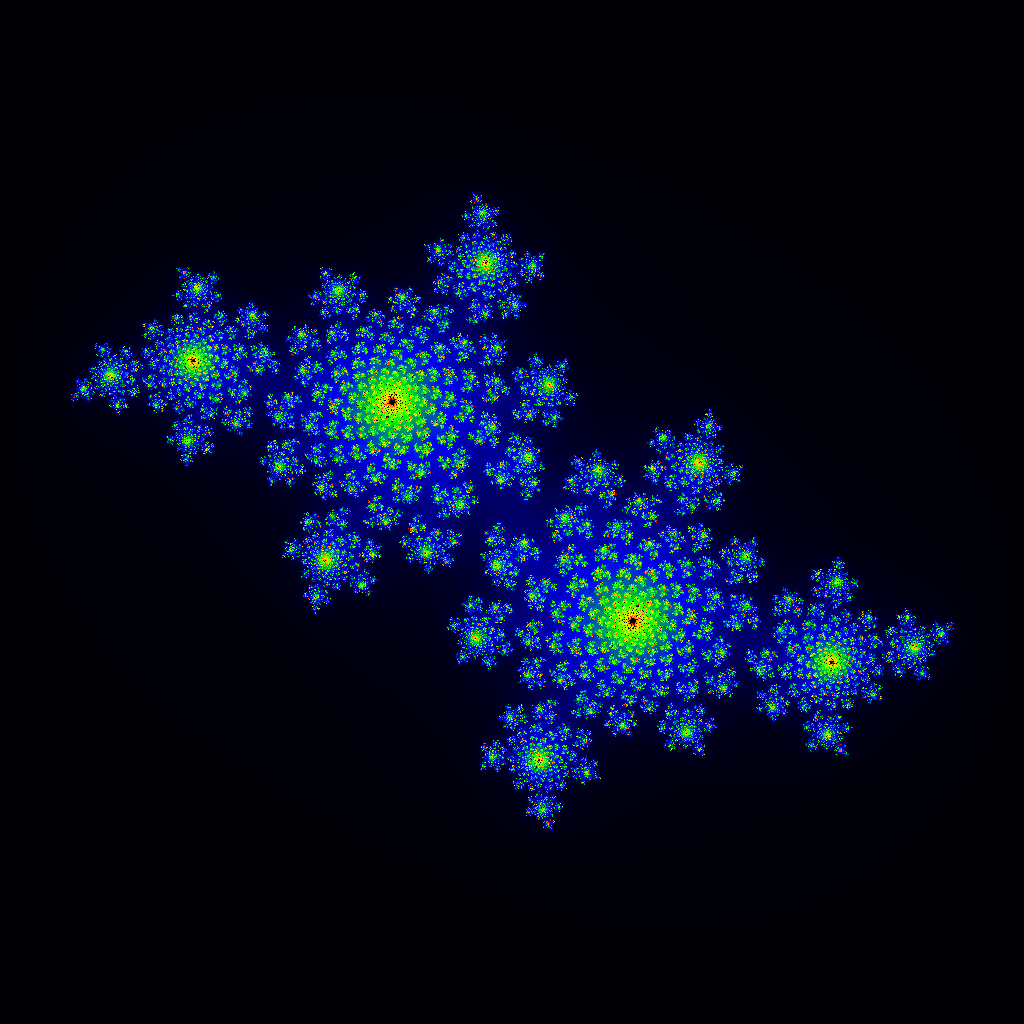

In [4]:
from IPython.display import Image
Image(filename='julia.png')

## Details on the image file
If you are interested how we go from iteration number to the images, check the `writePPM` in `julia.h`.
The ppm image format P3 is a simple and inefficient image format to dump the output of our kernel. In P3, we can simply write the RGB values of every pixel as ASCII numbers.
The files look as follows:
```
P3
width height
maxColorValue
RGB pixelValues (starting from top left pixel)
```
White spaces are ignored. , so the writePPM function adds tabs to separate the pixels and line breaks after each line.

In [16]:
%cat julia.ppm

P3
1024 1024
256
0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4

0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 

0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 

0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 

0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 8	0 0 8	0 0 8	0 0 8	0 0 8	0 0 8	0 0 8	0 0 8	0 0 8	0 0 8	0 0 8	0 0 8	0 0 8	0 0 8	0 0 8	0 0 8	0 0 8	0 0 8	0 0 8	0 0 8	0 0 8	0 0 8	0 0 8	0 0 8	0 0 8	0 0 8	0 0 8	0 0 8	0 0 8	0 0 8	0 0 8	0 0 8	0 0 8	0 0 8	0 0 8	0 0 8	0 0 8	0 0 8	0 0 8	0 0 8	0 0 8	0 0 8	0 0 8	0 0 8	0 0 8	0 0 8	0 0 8	0 0 8	0 0 8	0 0 8	0 0 8	0 0 8	0 0 8	0 0 8	0 0 8	0 0 8	0 0 8	0 0 8	0 0 8	0 0 8	0 0 8	0 0 8	0 0 8	0 0 8	0 0 8	0 0 8	0 0 8	0 0 8	0 0 8	0 0 8	0 0 8	0 0 8	0 0 8	0 0 8	0 0 8	0 0 8	0 0 8	0 0 8	0 0 8	0 0 8	0 0 8	0 0 

0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 4	0 0 8	0 0 8	0 0 8	0 0 8	0 0 8	0 0 8	0 0 8	0 0 8	0 0 8	0 0 8	0 0 8	0 0 8	0 0 8	0 0 8	0 0 8	0 0 8	0 0 8	0 0 8	0 0 8	0 0 8	0 0 8	0 0 8	0 0 8	0 0 8	0 0 8	0 0 8	0 0 8	0 0 8	0 0 8	0 0 8	0 0 8	0 0 8	0 0 8	0 0 8	0 0 8	0 0 8	0 0 8	0 0 8	0 0 8	0 0 8	0 0 8	0 0 8	0 0 8	0 0 8	0 0 8	0 0 8	0 0 8	0 0 8	0 0 8	0 0 8	0 0 8	0 0 8	0 0 8	0 0 8	0 0 8	0 0 8	0 0 8	0 0 8	0 0 8	0 0 8	0 0 12	0 0 12	0 0 12	0 0 12	0 0 12	0 0 12	0 0 12	0 0 12	0 0 12	0 0 12	0 0 12	0 0 12	0 0 12	0 0 12	0 0 12	0 0 12	0 0 12	0 0 12	0 0 12	0 0 12	0 0 12	0 0 12	0 0 12	0 0 12	0 0 12	0 0 12	0 0 12	0 0 12	0 0 12	0 0 12	0 0 12	0 0 12	0 0 12	0 0 12	0 0 12	0 0 12	0 0 12	0 0 12	0 0 12	0 0 12	0 0 12	0 0 12	0 0 12	0 0 12	0 0 12	0 0 12	0 0 16	0 0 16	0 0 16	0 0 16	0 0 16	0 0 16	0 0 16	0 0 16	0 0 16	0 0 16	0 0 16	0

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



# Bonus Tasks
## Floating-point precision
The draft kernel was using double precision for the complex numbers. Check if the usage of single-precision floating-point numbers give satisfying results, and check the impact on the kernel execution. How fast can we go?

## CPU equivalent
There is a naive CPU kernel called `juliaCPU` that can be used as a drop-in replacement for the GPU kernel. Check its speed. How much speed up against a single CPU thread can you reach with the GPU?

## Grid-strided loops for an image of arbitrary size
You might have written a kernel where `i = threadIdx.x`. The maximum number of threads per SM is 1024, so your kernel might not be able to deal with larger images. Remember that you can use the grid-strided loop to process an array of arbitray size. Try using a grid strided loop on an image of 2048x2048 pixels. You can use a linearised index from 0 to 2048x2048, and compute i and j using modulus and integer division.